# HYPERPARAMETER TUNING

In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Hyperparameter Space

1. **Learning Rate**
   - **Range:** 0.0001 to 0.01
   - **Reason:** Balances between rapid convergence and avoiding suboptimal solutions. Allows exploration from conservative to moderately aggressive learning steps.

2. **Batch Size**
   - **Range:** 16 to 128
   - **Reason:** Balances between noisy gradient estimates (small batch sizes) and stable but memory-intensive estimates (large batch sizes).

3. **Epochs**
   - **Range:** 1 to 3
   - **Reason:** Provides a preliminary tuning scope to avoid underfitting or overfitting, allowing efficient initial optimization.

By tuning these hyperparameters, we aim to enhance MobileNet's performance while balancing training efficiency and model accuracy.

In [16]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.01),
    'batch_size': IntegerParameter(16, 128),
    'epochs': IntegerParameter(1, 3)
}

In [17]:
bucket_name = 'sagemaker-us-west-2-577585731673'
prefix = 'deep-learning/project/mobileNet'
estimator = PyTorch(
    entry_point='MobileNetTraining.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [18]:
objective_metric_name = 'validation:f1_score'
metric_definitions = [
    {'Name': 'validation:accuracy', 'Regex': 'Validation Accuracy: ([0-9\\.]+)%'},
    {'Name': 'validation:f1_score', 'Regex': 'Validation F1-Score \\(weighted\\): ([0-9\\.]+)'}
]

In [19]:
# Create the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=3,
    objective_type='Maximize'
)

In [20]:
s3_bucket = 'awsmlnn-dev'
s3_key = 'data/data_project.zip'
tuner.fit({'train': f's3://{s3_bucket}/{s3_key}'})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [22]:
# Get the best hyperparameters
best_training_job = tuner.best_training_job()
best_estimator = PyTorch.attach(best_training_job)

# Print out the best hyperparameters
best_hyperparameters = best_estimator.hyperparameters()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml

2024-07-06 23:37:19 Starting - Found matching resource for reuse
2024-07-06 23:37:19 Downloading - Downloading the training image
2024-07-06 23:37:19 Training - Training image download completed. Training in progress.
2024-07-06 23:37:19 Uploading - Uploading generated training model
2024-07-06 23:37:19 Completed - Resource released due to keep alive period expiry


## TRAINING MODEL WITH BEST HYPERPARAMETERS

In [23]:
new_best_hyperparameters = {
    'batch_size': int(best_hyperparameters['batch_size']),
    'epochs': int(best_hyperparameters['epochs']),
    'lr': float(best_hyperparameters['lr'])
}

In [229]:
new_best_hyperparameters = {'batch_size': 128,
 'epochs': 1,
 'lr': 0.0025546374233166936}

In [25]:
new_best_hyperparameters

{'batch_size': 128, 'epochs': 1, 'lr': 0.0025546374233166936}

In [231]:
estimator = PyTorch(
    entry_point='MobileNetTrainingDebugProfile.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    hyperparameters= new_best_hyperparameters,
    output_path=f"s3://{bucket_name}/{prefix}/",
    checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/",
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [232]:
# Start the training job
estimator.fit({'train': f's3://{s3_bucket}/{s3_key}'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-07-12-06-54-35-554


Using provided s3_resource
2024-07-12 06:54:35 Starting - Starting the training job...
2024-07-12 06:54:50 Starting - Preparing the instances for training...
2024-07-12 06:55:11 Downloading - Downloading input data...
2024-07-12 06:55:46 Downloading - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-12 06:56:47,389 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-12 06:56:47,389 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-12 06:56:47,390 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-12 06:56:47,398 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-12 06:56:47,400 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-07-12 06:56:48,791 sagemaker-training-toolkit I

In [233]:
training_job_name = estimator.latest_training_job.name
print("training job name: ",training_job_name)
training_job_info = estimator.sagemaker_session.describe_training_job(training_job_name)
model_s3_uri = training_job_info['ModelArtifacts']['S3ModelArtifacts']
print(f"El modelo se ha almacenado en: {model_s3_uri}")

training job name:  pytorch-training-2024-07-12-06-54-35-554
El modelo se ha almacenado en: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-12-06-54-35-554/output/model.tar.gz


## MODEL DEPLOYMENT

In [31]:
from sagemaker.pytorch import PyTorchModel
import os
import random
import boto3
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import torch
import torch.nn.functional as F
import base64

In [28]:
model_s3_uri = "s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-12-06-54-35-554/output/model.tar.gz"

The following code deploy a PyTorch model for inference. The model is specified along with its parameters and then deployed to an instance.

In [30]:
pytorch_model = PyTorchModel(
    model_data= model_s3_uri,
    role=role,
    entry_point='inference.py',
    py_version='py310',
    framework_version='2.0.0',
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [31]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.2xlarge"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
------!

In [42]:
def get_label(numeric_value):
    labels_name = {0:'bag', 1:'bracelet', 2:'dress', 3:'earrings',
                   4:'eyewear', 5:'hats', 6:'necklace', 7:'outwear', 8:'pants',
                   9:'rings', 10:'shoes', 11:'skirt', 12:'top',13:'watches'}
    """Return the label corresponding to the numeric value."""
    return labels_name.get(numeric_value, "Unknown label")

### Sampling Random Images for Inference Testing

This code samples random images from the test dataset to test the inference model.

In [47]:
# Random select n images from the test dataset
def sample_images_from_random_categories(base_path, n_categories, sample_size=10):
    categories = os.listdir(base_path)
    sampled_images = []
    selected_categories = random.sample(categories, min(n_categories, len(categories)))
    for category in selected_categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            images = [os.path.join(category_path, img) for img in os.listdir(category_path)]
            sampled_images.extend(random.sample(images, min(sample_size, len(images))))
    return sampled_images

base_path = '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test'
n_categories = 10 
image_paths = sample_images_from_random_categories(base_path, n_categories, sample_size=1)

In [48]:
image_paths

['/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/bag/216416515_2.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/top/178470458_1.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/bracelet/21115913_4.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/earrings/209652761_5.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/hats/195354313_7.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/dress/198385791_1.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/watches/214775755_3.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/shoes/56638024_4.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/skirt/214386614_2.jpg',
 '/home/sagemaker-user/AWSNN/DL/Project/data/testing/test/rings/53246132_7.jpg']

In [34]:
def get_category_from_path(img_path):
    return img_path.split('/')[-2]
    
def imshow(img_path):
    img = Image.open(img_path)
    img = np.array(img) / 255.0
    plt.imshow(img)

### Function to Get Model Inferences

The get_prediction function retrieves the predicted class for an image using a SageMaker endpoint. The main steps are:

- Encode the Image: Convert the image to a base64 string.
- Invoke SageMaker Endpoint: Send the encoded image to the SageMaker endpoint.
- Process Response: Decode the response and extract the predicted class.

In [49]:
def encode_image_to_base64(image_path):
    """
    Encode an image file to a base64 string.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: Base64 encoded string of the image.
    """
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

In [50]:
def get_prediction(image_path, endpoint_name):
    encoded_image = encode_image_to_base64(image_path)
    input_data = {
        "instances": [
            {
                "image_bytes": {
                    "b64": encoded_image
                }
            }
        ]
    }
    input_json = json.dumps(input_data)
    runtime_client = boto3.client('sagemaker-runtime')
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=input_json
    )
    response_body = response['Body'].read()
    response_body_str = response_body.decode('utf-8')
    response_dict = json.loads(response_body_str)
    response_tensor = torch.tensor(response_dict)
    probabilities = F.softmax(response_tensor, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class

In [37]:
endpoint_name = 'pytorch-inference-2024-07-12-20-27-25-151' 

### Visualization of Image Inferences

The following code visualizes images along with their actual and predicted categories. Each image is displayed with a title indicating the actual category and the predicted label. The title color is green if the prediction is correct and red if it is incorrect.


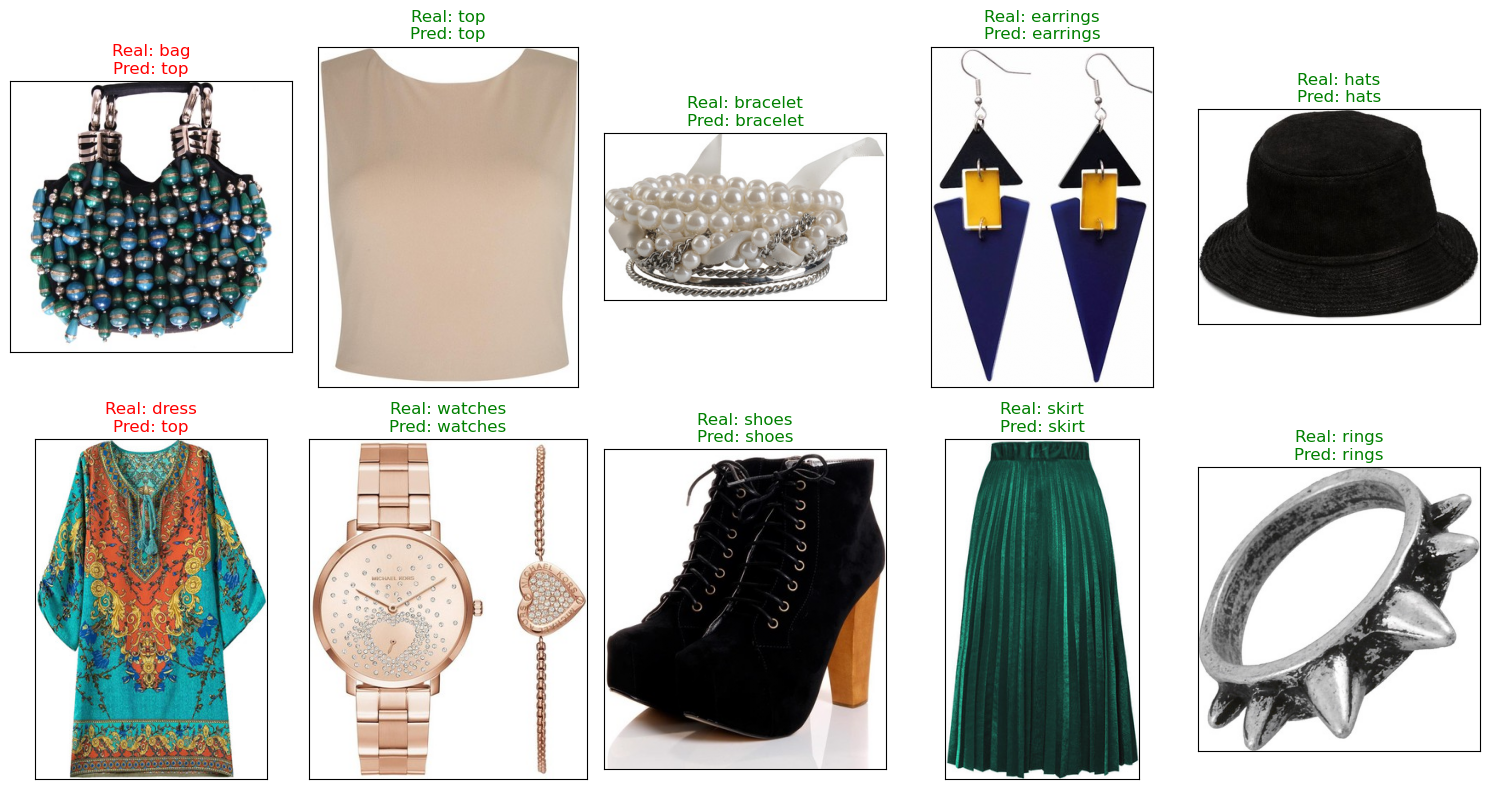

In [51]:
fig = plt.figure(figsize=(15, 8))
for idx in np.arange(min(10, len(image_paths))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    imshow(image_paths[idx])  # Mostrar la imagen
    category = get_category_from_path(image_paths[idx])
    predicted_class = get_prediction(image_paths[idx], endpoint_name)
    predicted_label = get_label(predicted_class)
    color = 'green' if category == predicted_label else 'red'
    ax.set_title(f"Real: {category}\nPred: {predicted_label}", color=color)  # Agregar la categoría y la predicción como título

plt.tight_layout()
plt.show()

In [52]:
def delete_endpoint(endpoint_name):
    sagemaker_client = boto3.client('sagemaker')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"Endpoint {endpoint_name} deleted.")

delete_endpoint(endpoint_name)

Endpoint pytorch-inference-2024-07-12-20-27-25-151 deleted.


## DEBUGGING AND PROFILE

In [55]:
from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerConfig, ProfilerRule, rule_configs, FrameworkProfile, CollectionConfig

debugging_rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.class_imbalance()),
    Rule.sagemaker(rule_configs.confusion()),
]

profiling_rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    #ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    ProfilerRule.sagemaker(rule_configs.IOBottleneck())
]

all_rules = debugging_rules + profiling_rules

# Profiler Configuration ]with adjusted intervals
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000  # Collect system metrics every second
)

In [62]:
new_best_hyperparameters = {'batch_size': 32,
 'epochs': 1,
 'lr': 0.0025546374233166936,
 'hook':1
}

In [63]:
bucket_name = 'sagemaker-us-west-2-577585731673'
prefix = 'deep-learning/project/mobileNet'
s3_bucket = 'awsmlnn-dev'
s3_key = 'data/data_project.zip'

In [64]:
collection_configs = [
    CollectionConfig(
        name="training_losses",
        parameters={
            "include_regex": ".*Loss.*",
            "train.save_interval": "100"
        }
    ),
    CollectionConfig(
        name="evaluation_metrics",
        parameters={
            "include_regex": ".*(Loss|Accuracy|F1-Score).*",
            "eval.save_interval": "50"
        }
    )
]

hook_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

In [65]:
estimator = PyTorch(
    entry_point='MobileNetTrainingDebugProfile.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    framework_version='2.0.0',
    py_version='py310',
    rules=all_rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    hyperparameters= new_best_hyperparameters,
    output_path=f"s3://{bucket_name}/{prefix}/",
    checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/",
    code_location=f"s3://{bucket_name}/{prefix}/"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [66]:
estimator.fit({'train': f's3://{s3_bucket}/{s3_key}'},wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-07-12-23-27-44-910


2024-07-12 23:27:45 Starting - Starting the training job...
2024-07-12 23:28:01 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ClassImbalance: InProgress
Confusion: InProgress
ProfilerReport: InProgress
CPUBottleneck: InProgress
IOBottleneck: InProgress
...
2024-07-12 23:28:41 Downloading - Downloading input data...
2024-07-12 23:29:04 Downloading - Downloading the training image......
2024-07-12 23:30:02 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-12 23:30:08,748 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-12 23:30:08,748 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-12 23:30:08,749 sagemaker-training-tool

In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [16]:
! aws s3 ls {rule_output_path} --recursive

2024-07-07 20:06:35     329696 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-07-07 20:06:34     171070 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-07-07 20:06:31        191 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-07-07 20:06:31        199 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-07-07 20:06:31        126 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-07-07 20:06:31        127 deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/Profi

In [17]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-07-19-59-17-991/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler

In [18]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [111]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [46]:
#!pip install smdebug

In [352]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
tensor_names = trial.tensor_names()
print(tensor_names)

[2024-07-08 05:12:49.775 default:166 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-577585731673/deep-learning/project/mobileNet/pytorch-training-2024-07-08-05-05-23-291/debug-output
['CrossEntropyLoss_input_0', 'CrossEntropyLoss_input_1', 'CrossEntropyLoss_output_0', 'gradient/MobileNetV3_model.classifier.3.bias', 'gradient/MobileNetV3_model.classifier.3.weight', 'labels', 'outputs', 'scalar/Validation Accuracy', 'scalar/Validation F1-Score']


In [353]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


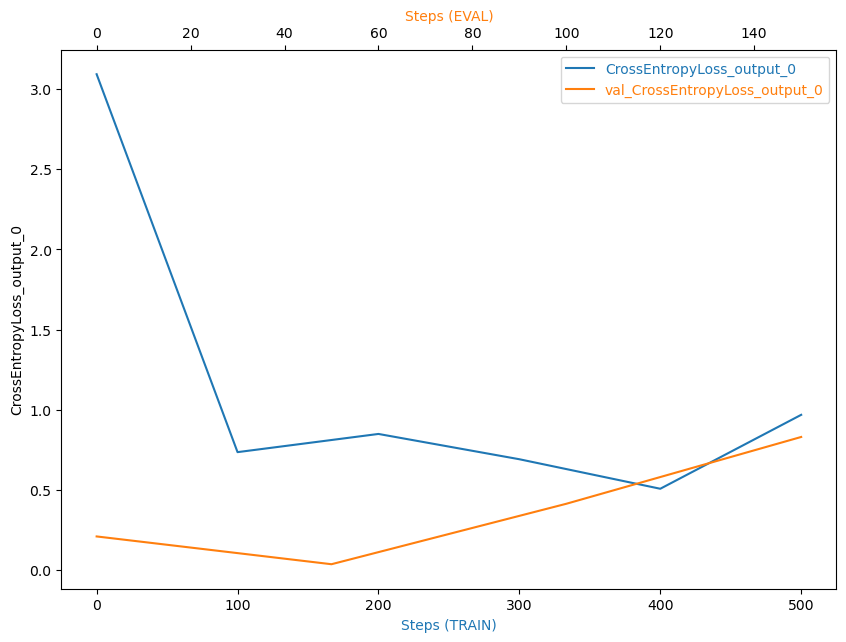

In [354]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

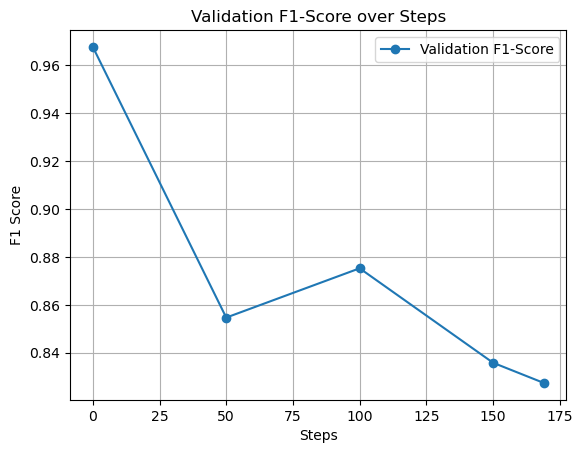

In [370]:
tensor_name = 'scalar/Validation F1-Score'
steps, vals = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
plt.plot(steps, vals, label='Validation F1-Score', marker='o')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.title('Validation F1-Score over Steps')
plt.legend()
plt.grid(True)
plt.show()